### Imports

In [7]:
import pandas as pd
import pycountry
import re
import numpy as np

pd.set_option('display.max_columns', None)

### Cleaning & Filtering necessary columns

In [3]:
df = pd.read_excel("../Data/raw/O&D.xlsx", sheet_name='Order & Delivery Updated 2025')

In [5]:
columns_to_keep = {
    "CT String Revenue Recognition Date": "Date",
    "Weight": "Weight",
    "Tubing Revenue": "Revenue",
    "Grade": "Grade",
    "name Gauge Clean": "Gauge",
    "Product ID String Type": "Wall type",
    "Ship To Address": "Ship to",
    "String No": "String",
}

df = df[list(columns_to_keep.keys())].rename(columns=columns_to_keep)

In [6]:
len(df['String'].unique().tolist())

2263

### Extracting Country from shipping address

In [8]:
df['Ship to'] = df['Ship to'].astype(str)

all_country_names = set()
for country in pycountry.countries:
    all_country_names.add(country.name.lower())
    if hasattr(country, 'official_name'):
        all_country_names.add(country.official_name.lower())
    if hasattr(country, 'common_name'):
        all_country_names.add(country.common_name.lower())
    # Add short forms manually
    all_country_names.update([
        country.alpha_2.lower(),
        country.alpha_3.lower()
    ])

def extract_country(text):
    text_lower = text.lower()
    for name in all_country_names:
        if name in text_lower:
            match = pycountry.countries.get(name=name.title())
            if match:
                return match.name
    return np.nan

def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = re.sub(r'_x000D_|\\n|\\r|\n|\r', ' ', text)  # remove line breaks
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove punctuation
    return re.sub(r'\s+', ' ', text.strip()).lower()

In [9]:
df['Ship to'] = df['Ship to'].apply(clean_text)

df['Country'] = df['Ship to'].apply(extract_country)

In [10]:
df[df["Country"].isnull()]["Ship to"].unique()

array(['redhawk midland tx', 'global tubing stock workstring',
       'petroleum equipment supplies fze 4800 w greens rd houston tx 77066 for export to saudi',
       'gladiator energy midland', 'gladiator midland',
       'red zone coil tubing kilgore tx 75662 usa',
       'global tubing red deer 775447th ave close red deer ab t4p 2j9',
       'core completions', 'step williston',
       'halliburton energy services for export to saudi',
       'halliburton worldwide limited mussaffah ind area icad 2 sector 107gr12 106hr9 abu dhabi adh ae',
       'procoil tubing 4201 s cr 1141 midland tx 79706 usa',
       'pars drilling anadolu aslan sondaj mteahhitlii ve tic a mustafa kemal mah 2118 cad no4 maidan is ve yasam merkezi b blok kat15 tel 90 312 286 53 53 cankaya ankara turkey',
       'gladiator energy services midland tx', 'nan',
       'cudd pressure control 723 south merritt road elk city ok 73644 usa',
       'cudd pressure control 723 s merritt rd elk city tx 73644 usa',
       'c

### Manual Mapping

In [11]:
manual_country_map = {
    # United States
    'texas': 'United States',
    'tx': 'United States',
    'la': 'United States',
    'ca': 'United States',
    'ok': 'United States',
    'dayton': 'United States',
    'union city': 'United States',
    'nd': 'United States',
    'pa': 'United States',
    'smithton': 'United States',
    'co': 'United States',
    'odessa': 'United States',

    # Canada
    'red deer': 'Canada',
    'ab': 'Canada',
    'grande prairie': 'Canada',
    'bow valley square': 'Canada',
    'strathcona resources': 'Canada',
    'quality tubing': 'Canada',
    'evolvex': 'Canada',
    'xdi energy': 'Canada',

    # Mexico
    'veracruz': 'Mexico',
    'nuevo leon': 'Mexico',
    'villahermosa': 'Mexico',
    'cuernavaca': 'Mexico',
    'queretaro': 'Mexico',
    'cumuapa': 'Mexico',
    'mx': 'Mexico',
    'mexico': 'Mexico',

    # Saudi Arabia
    'udhailiyah': 'Saudi Arabia',
    'saudi': 'Saudi Arabia',

    # United Arab Emirates
    'abu dhabi': 'United Arab Emirates',
    'dubai': 'United Arab Emirates',
    'uae': 'United Arab Emirates',
    'mussafah': 'United Arab Emirates',
    'jebel ali': 'United Arab Emirates',

    # Rest of World
    'uk': 'United Kingdom',
    'cote divoire': "Côte d'Ivoire",
    'ivory coast': "Côte d'Ivoire",
    'trinidad': 'Trinidad and Tobago',
    'neuquen': 'Argentina',
    'arg': 'Argentina',
    'vietnam': 'Vietnam',
    'bolivia': 'Bolivia',
    'well services group phileas': 'Netherlands',
}


In [12]:
def match_manual_country(text):
    for keyword, country in manual_country_map.items():
        if keyword in text:
            return country
    return np.nan

df['Country'] = df['Country'].fillna(df['Ship to'].apply(match_manual_country))

df = df.dropna(subset=['Country']).reset_index(drop=True)

df = df.drop('Ship to', axis=1)

In [13]:
df

,Date,Weight,Revenue,Grade,Gauge,Wall type,String,Country
0,2023-08-14 05:00:00,113580.0,218200.000000,DC-110,0.25,SW,13190,United Kingdom
1,2023-08-11 05:00:00,113580.0,218200.000000,DC-110,0.25,SW,13191,United Kingdom
2,2023-07-29 00:00:00,101947.5,188184.043939,DC-120,0.224,SW,13157,United States
3,2024-11-30 06:00:00,101356.4,112565.000000,GT-90,0.145,SW,14325,Norway
4,2022-04-12 05:00:00,99748.0,90640.891879,GT-90,0.156,SW,11736,Saudi Arabia
...,...,...,...,...,...,...,...,...
13206,2025-05-31 05:00:00,2488.0,4267.039242,DC-110,.134 - .145,CT,14626,United States
13207,2025-05-31 05:00:00,2392.2,4102.737650,DC-110,.145 - .156,CT,14626,United States
13208,2025-05-31 05:00:00,2946.0,5052.531192,DC-110,.156 - .175,CT,14626,United States
13209,2025-05-31 05:00:00,2535.2,4347.989504,DC-110,.175 - .190,CT,14626,United States


In [14]:
unique_countries_per_string = df.groupby('String')['Country'].nunique()

# Step 2: Check for any 'String' with more than 1 unique country
problematic_strings = unique_countries_per_string[unique_countries_per_string > 1]

if problematic_strings.empty:
    print("One Country per String")
else:
    print("❌ Some String values are linked to multiple Countries:")
    print(problematic_strings)

❌ Some String values are linked to multiple Countries:
String
11773    2
11971    2
12141    2
12231    2
12463    2
12466    2
12511    2
12633    2
12880    2
13274    2
13543    2
Name: Country, dtype: int64


In [15]:
problematic_strings = [
    11773, 11971, 12141, 12231, 12463, 12466, 12511, 12633, 12880, 13274, 13543
]

df_clean = df[~df['String'].isin(problematic_strings)].copy()

# 3. Create a unique mapping DataFrame: each String maps to one Country
mapping_df = df_clean[['String', 'Country']].drop_duplicates().reset_index(drop=True)

In [16]:
mapping_df.to_csv('../Data/processed/String_Country_Map.csv', index=False)

### Volume per Country

In [17]:
import matplotlib.pyplot as plt

In [18]:
country_volume = df.groupby('Country', as_index=False)['Weight'].sum().sort_values(by='Weight', ascending=False)

country_revenue = df.groupby('Country', as_index=False)['Revenue'].sum().sort_values(by='Revenue', ascending=False)

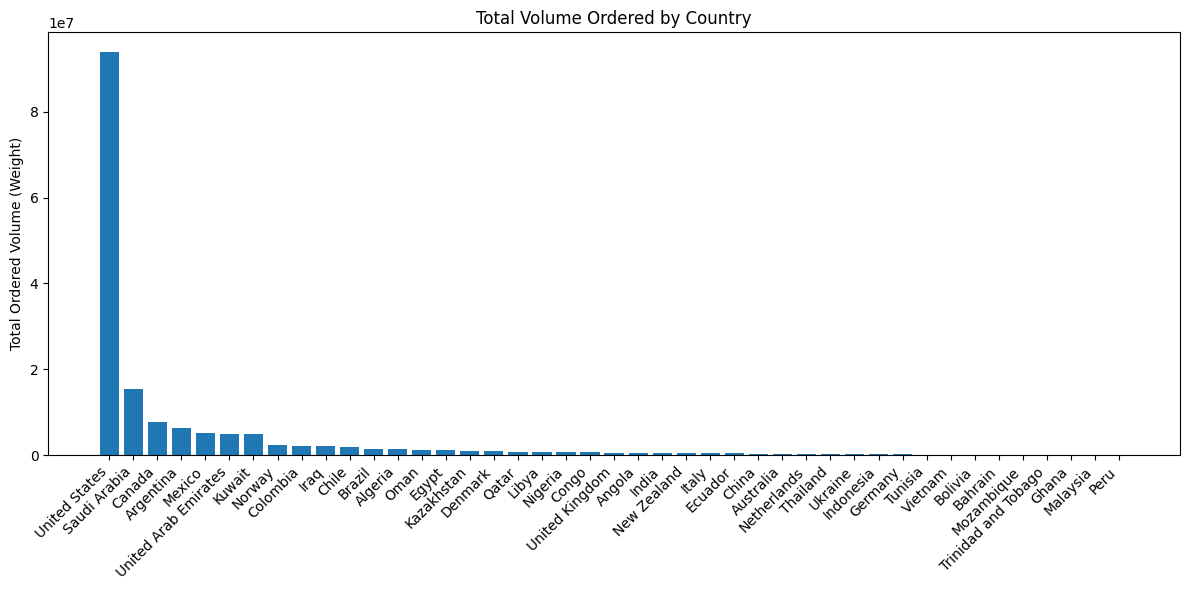

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(country_volume['Country'], country_volume['Weight'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Ordered Volume (Weight)')
plt.title('Total Volume Ordered by Country')
plt.tight_layout()
plt.show()

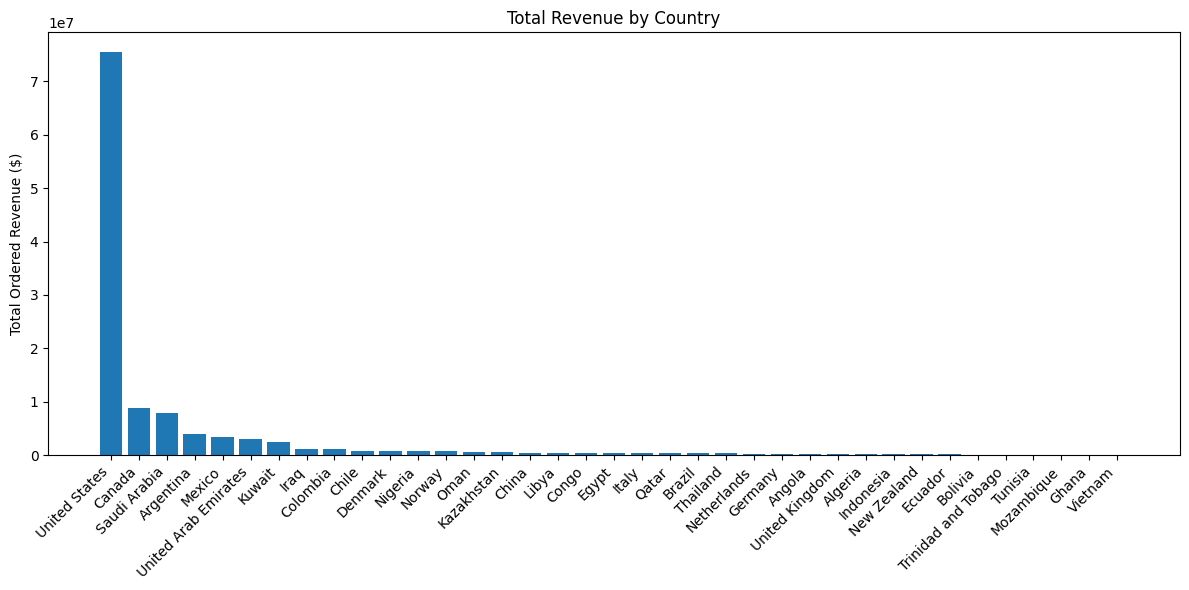

In [70]:
plt.figure(figsize=(12, 6))
plt.bar(country_revenue['Country'], country_revenue['Revenue'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Ordered Revenue ($)')
plt.title('Total Revenue by Country')
plt.tight_layout()
plt.show()

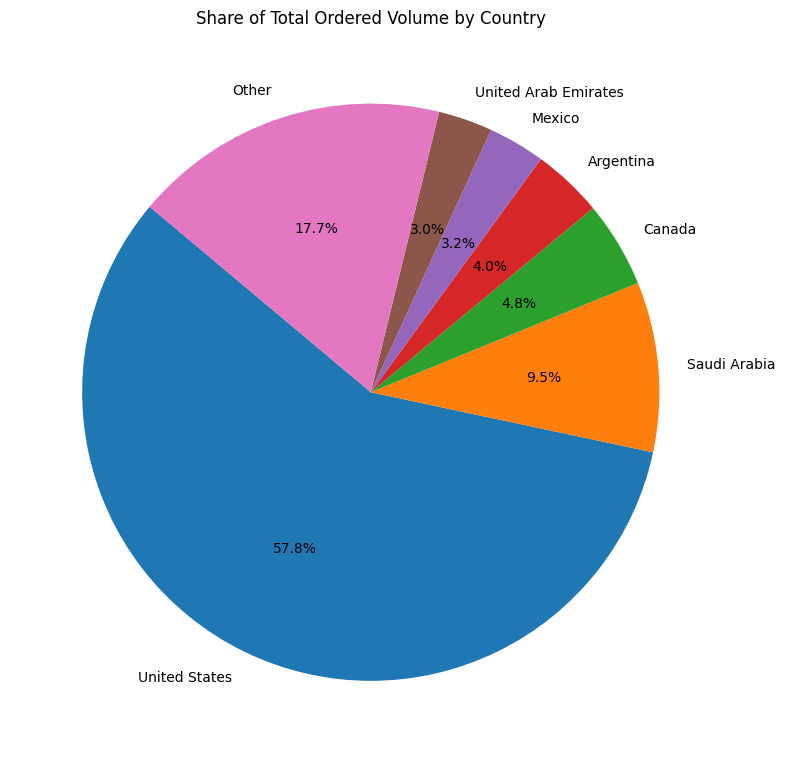

In [20]:
top_6 = country_volume.head(6)

# Compute "Other" category
other_weight = country_volume['Weight'].iloc[6:].sum()
other_row = pd.DataFrame({'Country': ['Other'], 'Weight': [other_weight]})

# Combine
final_pie_df = pd.concat([top_6, other_row], ignore_index=True)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(final_pie_df['Weight'], labels=final_pie_df['Country'], autopct='%1.1f%%', startangle=140)
plt.title('Share of Total Ordered Volume by Country')
plt.tight_layout()
plt.show()